# Crop Recommendation System

A multi-class classification model that recommends suitable crops based on soil and environmental conditions. The model outputs **multiple crop recommendations** with probability percentages, not just a single prediction.

**Features used:**
- N, P, K (Nitrogen, Phosphorus, Potassium levels in soil)
- Temperature, Humidity, pH, Rainfall

**Dataset:** 2,200 samples across 22 crop types (balanced - 100 samples each)


## 1. Setup and Imports


In [69]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model
import lightgbm as lgb

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 2. Load Dataset


In [70]:
# Load the dataset
# Note: The file has .xls extension but is actually CSV format
df = pd.read_csv('../data/crop_recommendation.xls')

print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of crop types: {df['label'].nunique()}")
print()
df.head(10)


Dataset shape: (2200, 8)
Number of samples: 2200
Number of features: 7
Number of crop types: 22



,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


In [71]:
# Dataset info
print("Dataset Info:")
print("-" * 40)
df.info()
print()
print("Missing values:")
print(df.isnull().sum())


Dataset Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Missing values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


## 3. Exploratory Data Analysis (Light)


In [72]:
# Statistical summary of features
df.describe().T


,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117


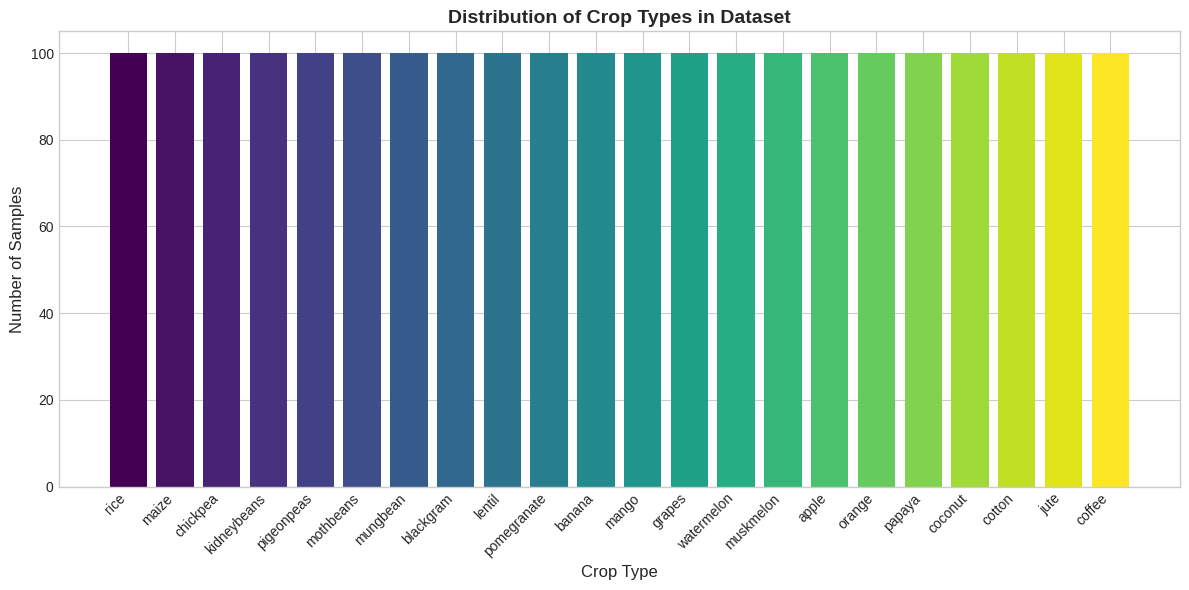

Dataset is perfectly balanced: 1 unique count values


In [73]:
# Crop type distribution
fig, ax = plt.subplots(figsize=(12, 6))
crop_counts = df['label'].value_counts()
bars = ax.bar(crop_counts.index, crop_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(crop_counts))))
ax.set_xlabel('Crop Type', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Distribution of Crop Types in Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Dataset is perfectly balanced: {crop_counts.nunique()} unique count values")


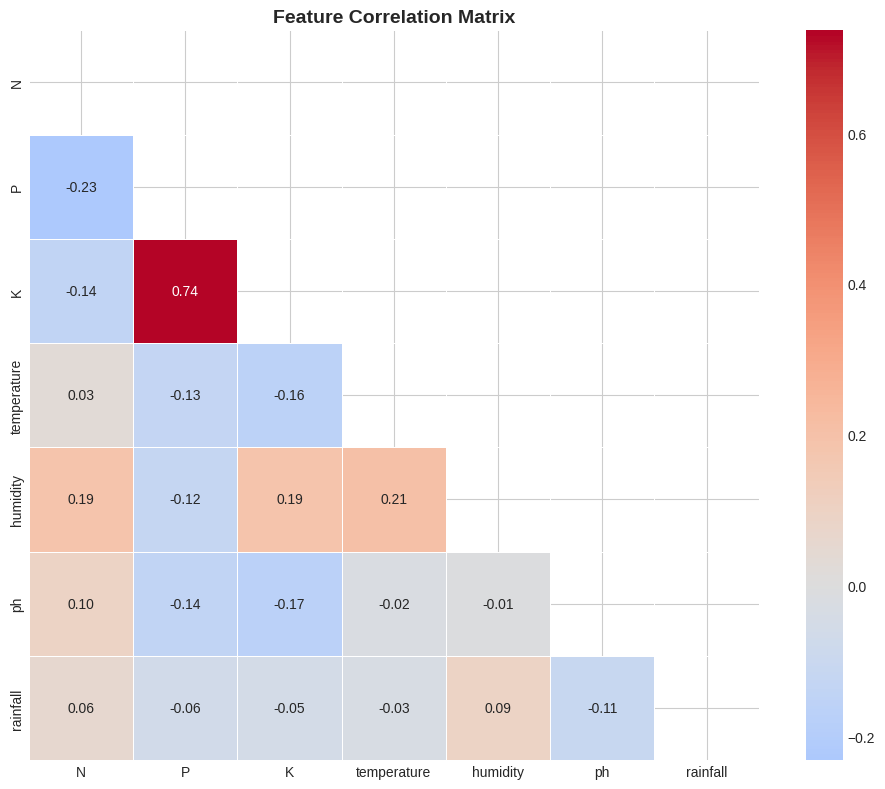

In [74]:
# Correlation heatmap of features
fig, ax = plt.subplots(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


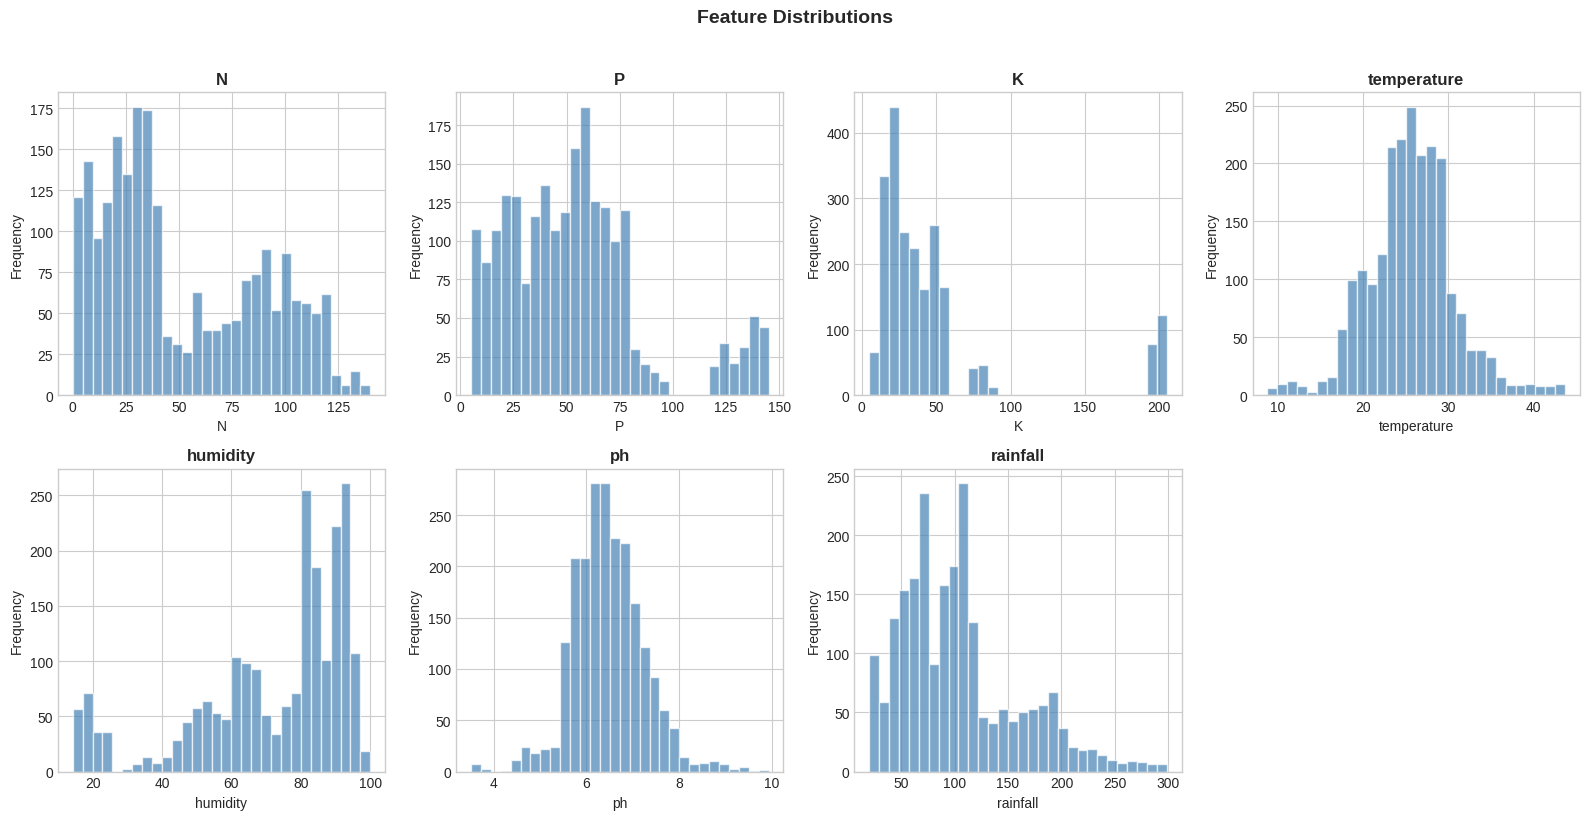

In [75]:
# Feature distributions
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=30, color='steelblue', edgecolor='white', alpha=0.7)
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Hide the last empty subplot
axes[-1].axis('off')

plt.suptitle('Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 4. Data Preprocessing


In [76]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Crop Classes:")
for i, crop in enumerate(label_encoder.classes_):
    print(f"  {i}: {crop}")
print(f"\nTotal classes: {len(label_encoder.classes_)}")


Crop Classes:
  0: apple
  1: banana
  2: blackgram
  3: chickpea
  4: coconut
  5: coffee
  6: cotton
  7: grapes
  8: jute
  9: kidneybeans
  10: lentil
  11: maize
  12: mango
  13: mothbeans
  14: mungbean
  15: muskmelon
  16: orange
  17: papaya
  18: pigeonpeas
  19: pomegranate
  20: rice
  21: watermelon

Total classes: 22


In [77]:
# Split data: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Second split: 50% of temp = 15% each for val and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dataset Split Summary:")
print("-" * 40)
print(f"Training set:   {len(X_train):4d} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val):4d} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test):4d} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total:          {len(X):4d} samples")


Dataset Split Summary:
----------------------------------------
Training set:   1540 samples (70.0%)
Validation set:  330 samples (15.0%)
Test set:        330 samples (15.0%)
Total:          2200 samples


In [78]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling applied (StandardScaler)")
print(f"Mean of scaled training features: {X_train_scaled.mean(axis=0).round(6)}")
print(f"Std of scaled training features:  {X_train_scaled.std(axis=0).round(6)}")


Feature scaling applied (StandardScaler)
Mean of scaled training features: [ 0.  0.  0.  0. -0. -0. -0.]
Std of scaled training features:  [1. 1. 1. 1. 1. 1. 1.]


## 5. Model Training (LightGBM)


In [79]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train_scaled, label=y_train)
val_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

# LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("Training LightGBM model...")
print("=" * 50)


Training LightGBM model...


In [80]:
# Train the model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

print(f"\nBest iteration: {model.best_iteration}")


Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0235213	valid's multi_logloss: 0.0525514
[100]	train's multi_logloss: 0.000461802	valid's multi_logloss: 0.0260709
Early stopping, best iteration is:
[98]	train's multi_logloss: 0.000537941	valid's multi_logloss: 0.0257099

Best iteration: 98


## 6. Model Evaluation


In [81]:
# Predictions on all sets
y_train_pred = model.predict(X_train_scaled).argmax(axis=1)
y_val_pred = model.predict(X_val_scaled).argmax(axis=1)
y_test_pred = model.predict(X_test_scaled).argmax(axis=1)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Model Performance:")
print("=" * 50)
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")


Model Performance:
Training Accuracy:   1.0000 (100.00%)
Validation Accuracy: 0.9939 (99.39%)
Test Accuracy:       0.9939 (99.39%)


In [82]:
# Classification report on test set
print("Classification Report (Test Set):")
print("=" * 70)
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report (Test Set):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
   blackgram       1.00      1.00      1.00        15
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
      grapes       1.00      1.00      1.00        15
        jute       0.94      1.00      0.97        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      0.93      0.97        15
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
   mothbeans       0.94      1.00      0.97        15
    mungbean       1.00      1.00      1.00        15
   muskmelon       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00    

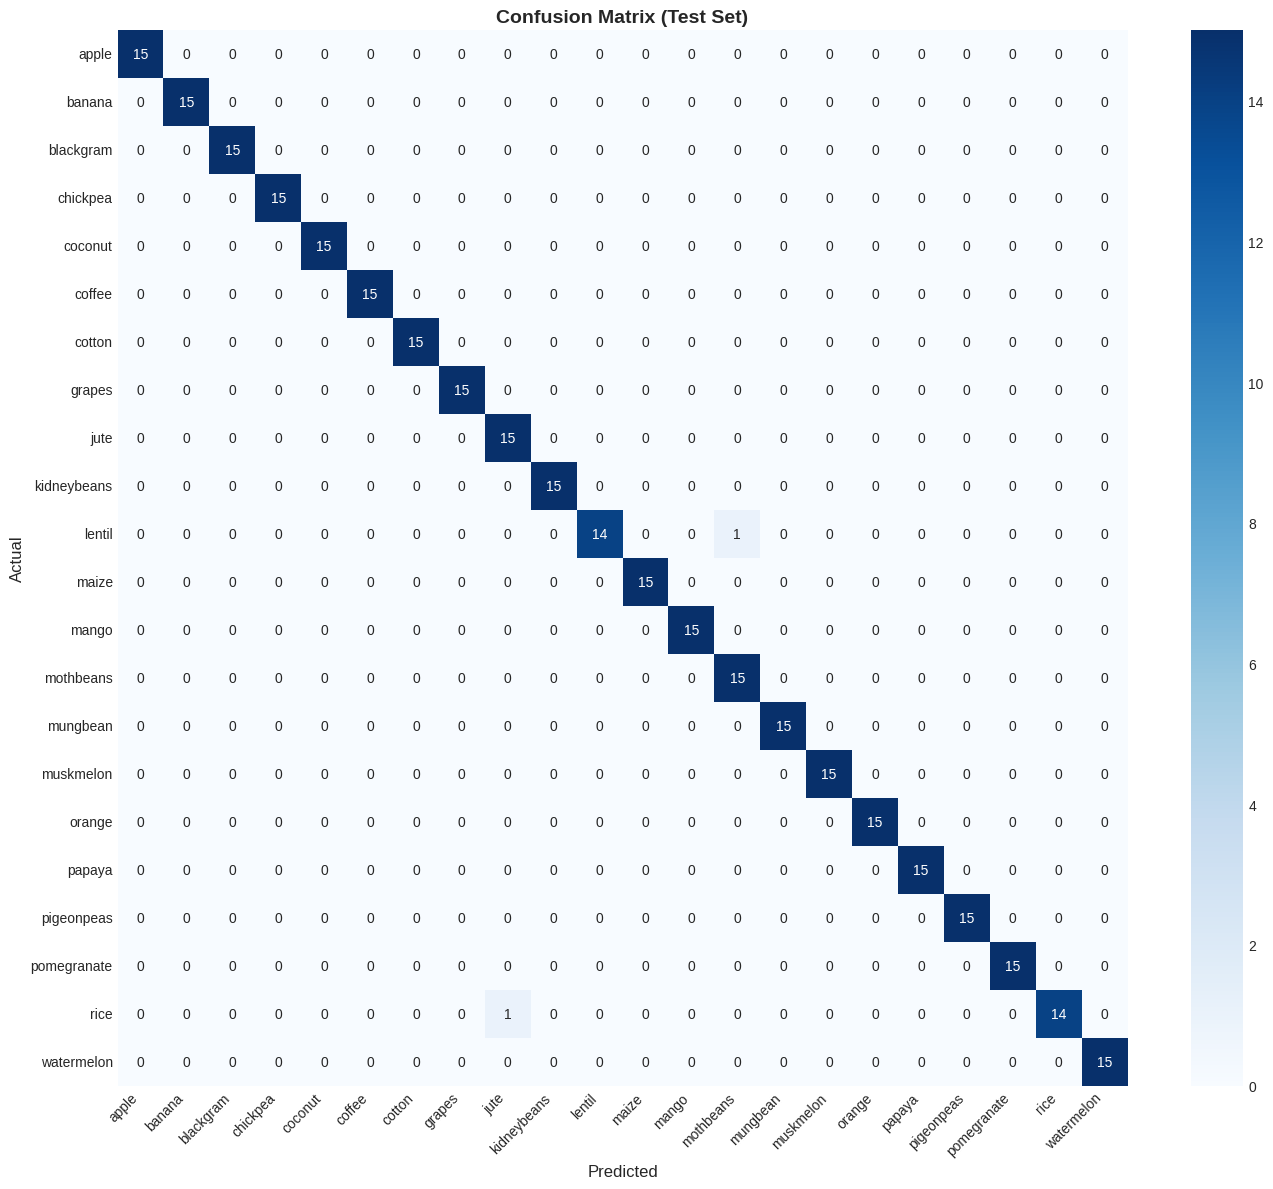

In [83]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


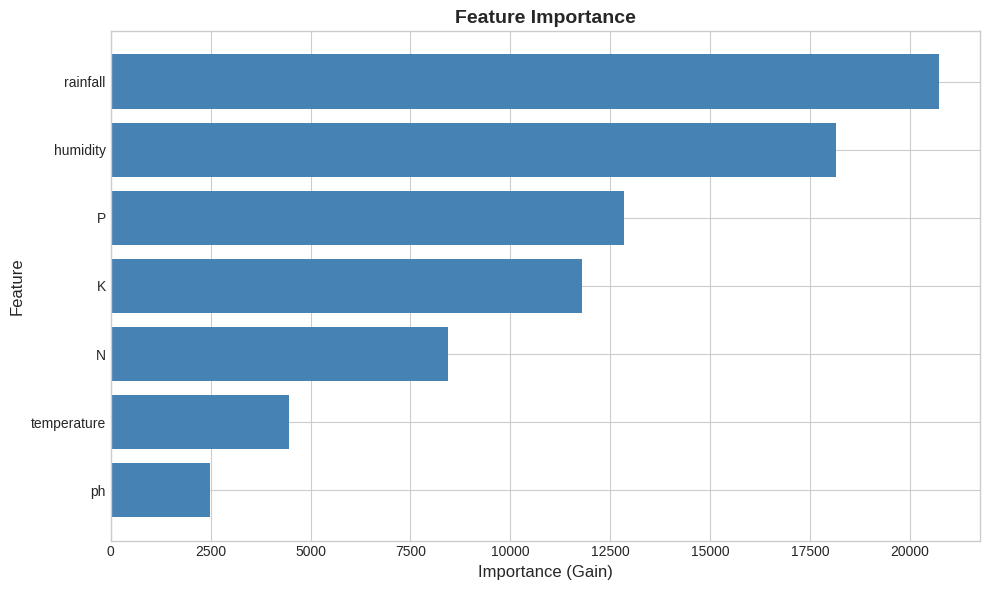

In [84]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
ax.set_xlabel('Importance (Gain)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 7. Multi-Crop Recommendation Function

The key feature of this model: instead of returning just a single crop prediction, it returns **multiple crops ranked by probability**, giving farmers more options to consider.


In [85]:
def recommend_crops(N, P, K, temperature, humidity, ph, rainfall, top_n=5):
    """
    Recommend crops based on soil and environmental conditions.
    
    Parameters:
    -----------
    N : float
        Nitrogen content in soil (kg/ha)
    P : float
        Phosphorus content in soil (kg/ha)
    K : float
        Potassium content in soil (kg/ha)
    temperature : float
        Temperature in Celsius
    humidity : float
        Relative humidity in %
    ph : float
        pH value of soil
    rainfall : float
        Rainfall in mm
    top_n : int
        Number of top recommendations to return (default: 5)
    
    Returns:
    --------
    list of tuples: [(crop_name, probability_percentage), ...]
    """
    # Create feature array
    features = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Get probability predictions for all classes
    probabilities = model.predict(features_scaled)[0]
    
    # Get top N indices sorted by probability (descending)
    top_indices = np.argsort(probabilities)[::-1][:top_n]
    
    # Create list of (crop_name, probability_percentage)
    recommendations = []
    for idx in top_indices:
        crop_name = label_encoder.classes_[idx]
        prob_percent = probabilities[idx] * 100
        recommendations.append((crop_name, prob_percent))
    
    return recommendations


def print_recommendations(recommendations):
    """Pretty print crop recommendations."""
    print("\n" + "=" * 50)
    print("🌾 CROP RECOMMENDATIONS")
    print("=" * 50)
    for rank, (crop, prob) in enumerate(recommendations, 1):
        bar_length = int(prob / 2)  # Scale for visualization
        bar = "█" * bar_length
        print(f"  {rank}. {crop:15s} {prob:6.2f}%  {bar}")
    print("=" * 50)


## 8. Example Usage and Demo


In [86]:
# Example 1: Conditions favorable for rice
print("Example 1: High humidity, moderate temperature, good rainfall")
print("Input: N=90, P=42, K=43, temp=20.8°C, humidity=82%, pH=6.5, rainfall=203mm")

recommendations = recommend_crops(
    N=90, P=42, K=43, 
    temperature=20.8, humidity=82, ph=6.5, rainfall=203,
    top_n=5
)
print_recommendations(recommendations)


Example 1: High humidity, moderate temperature, good rainfall
Input: N=90, P=42, K=43, temp=20.8°C, humidity=82%, pH=6.5, rainfall=203mm

🌾 CROP RECOMMENDATIONS
  1. rice             99.92%  █████████████████████████████████████████████████
  2. jute              0.03%  
  3. kidneybeans       0.01%  
  4. maize             0.00%  
  5. apple             0.00%  


In [87]:
# Example 2: Different soil conditions
print("Example 2: Low nitrogen, high potassium, tropical climate")
print("Input: N=20, P=60, K=200, temp=28°C, humidity=75%, pH=6.0, rainfall=100mm")

recommendations = recommend_crops(
    N=20, P=60, K=200, 
    temperature=28, humidity=75, ph=6.0, rainfall=100,
    top_n=5
)
print_recommendations(recommendations)


Example 2: Low nitrogen, high potassium, tropical climate
Input: N=20, P=60, K=200, temp=28°C, humidity=75%, pH=6.0, rainfall=100mm

🌾 CROP RECOMMENDATIONS
  1. chickpea         91.87%  █████████████████████████████████████████████
  2. grapes            2.12%  █
  3. pigeonpeas        0.68%  
  4. jute              0.36%  
  5. mango             0.28%  


In [88]:
# Example 3: Coffee-like conditions
print("Example 3: Moderate conditions suitable for coffee")
print("Input: N=100, P=25, K=30, temp=25°C, humidity=58%, pH=6.8, rainfall=150mm")

recommendations = recommend_crops(
    N=100, P=25, K=30, 
    temperature=25, humidity=58, ph=6.8, rainfall=150,
    top_n=5
)
print_recommendations(recommendations)


Example 3: Moderate conditions suitable for coffee
Input: N=100, P=25, K=30, temp=25°C, humidity=58%, pH=6.8, rainfall=150mm

🌾 CROP RECOMMENDATIONS
  1. coffee           99.98%  █████████████████████████████████████████████████
  2. jute              0.01%  
  3. coconut           0.00%  
  4. pigeonpeas        0.00%  
  5. cotton            0.00%  


Full probability distribution for Example 2:
--------------------------------------------------


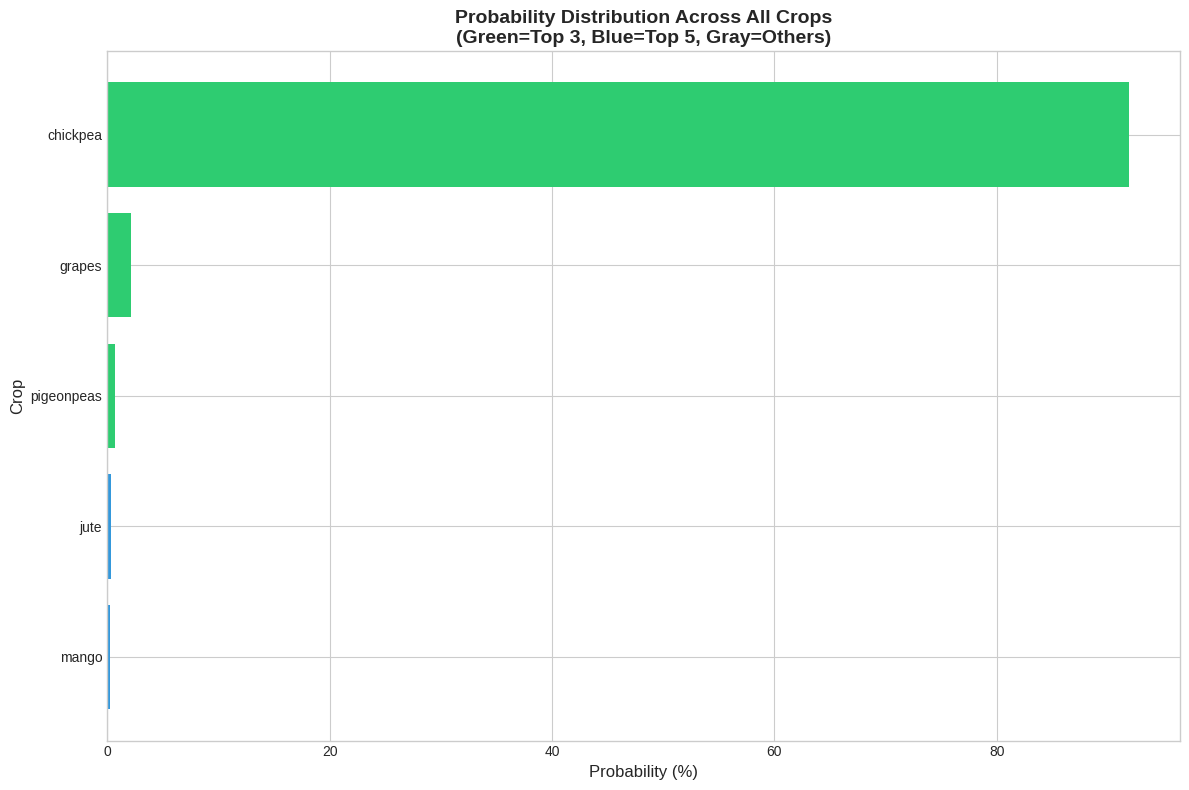


Top 5 recommendations:
 Rank       Crop  Probability (%)
    1   chickpea        91.868116
    2     grapes         2.117070
    3 pigeonpeas         0.679949
    4       jute         0.355315
    5      mango         0.278170


In [89]:
# Show full probability distribution for Example 2
print("Full probability distribution for Example 2:")
print("-" * 50)

all_recommendations = recommend_crops(
    N=20, P=60, K=200, 
    temperature=28, humidity=75, ph=6.0, rainfall=100,
    top_n=5
)

# Create DataFrame for better visualization
prob_df = pd.DataFrame(all_recommendations, columns=['Crop', 'Probability (%)'])
prob_df['Rank'] = range(1, len(prob_df) + 1)
prob_df = prob_df[['Rank', 'Crop', 'Probability (%)']]

# Display as bar chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#2ecc71' if i < 3 else '#3498db' if i < 5 else '#95a5a6' 
          for i in range(len(prob_df))]
bars = ax.barh(prob_df['Crop'][::-1], prob_df['Probability (%)'][::-1], color=colors[::-1])
ax.set_xlabel('Probability (%)', fontsize=12)
ax.set_ylabel('Crop', fontsize=12)
ax.set_title('Probability Distribution Across All Crops\n(Green=Top 3, Blue=Top 5, Gray=Others)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 5 recommendations:")
print(prob_df.head().to_string(index=False))


## 9. Summary

This notebook demonstrates a crop recommendation system that:
1. Uses **LightGBM** for multi-class classification across 22 crop types
2. Splits data into **train (70%) / validation (15%) / test (15%)**
3. Returns **multiple crop recommendations** with probability percentages
4. Provides a simple `recommend_crops()` function for easy inference

### How to Use:

```python
# Get top 5 crop recommendations
recommendations = recommend_crops(
    N=90,           # Nitrogen content (kg/ha)
    P=42,           # Phosphorus content (kg/ha)
    K=43,           # Potassium content (kg/ha)
    temperature=20, # Temperature (°C)
    humidity=80,    # Humidity (%)
    ph=6.5,         # Soil pH
    rainfall=200,   # Rainfall (mm)
    top_n=5         # Number of recommendations
)

# Returns: [('rice', 85.2%), ('jute', 8.1%), ...]
```


In [90]:
# Final model summary
print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(f"Algorithm:          LightGBM (Gradient Boosting)")
print(f"Number of classes:  {len(label_encoder.classes_)}")
print(f"Number of features: {len(X.columns)}")
print(f"Best iteration:     {model.best_iteration}")
print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")
print("-" * 60)
print(f"Test Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 60)
print("\nCrop classes:", list(label_encoder.classes_))


MODEL SUMMARY
Algorithm:          LightGBM (Gradient Boosting)
Number of classes:  22
Number of features: 7
Best iteration:     98
Training samples:   1540
Validation samples: 330
Test samples:       330
------------------------------------------------------------
Test Accuracy:      0.9939 (99.39%)

Crop classes: ['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']


## 10. Save Model


In [91]:
import pickle
import os

# Free cached training data to reduce model size
model.free_dataset()

# Save model, scaler, and label encoder together for inference
model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': list(X.columns)
}

model_path = '../models/crop_recommendation.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

file_size = os.path.getsize(model_path) / 1024  # KB
print(f"Model saved to: {model_path}")
print(f"File size: {file_size:.1f} KB")
print(f"Package contents: {list(model_package.keys())}")


Model saved to: ../models/crop_recommendation.pkl
File size: 7404.3 KB
Package contents: ['model', 'scaler', 'label_encoder', 'feature_names']
